Analysis of pupil data
======================

There are many valid approaches to the analysis of pupillometry data, but the optimal approach will depend on the type of experiment being run and the research question in mind. [Kelbsch et al. (2019)](https://www.frontiersin.org/articles/10.3389/fneur.2019.00129/full) provide an informative view on standards in pupillometry, and there are [some](https://github.com/samhforbes/PupillometryR) [great](https://github.com/beOn/cili) [examples](https://github.com/ihrke/pypillometry) of community-developed packages for streamlining pupillometry data analysis. Whilst it is always worth exploring the wider options that are available, *PyPlr* includes a set of pandas-reliant (you won't regret learning pandas) scripting tools for implementing a standard data processing pipeline that is optimised to work with some of the idiosynchrasies of Pupil Labs data. So far we have found these tools to be adequate for analysing our own data, but we welcome suggestions for improvements. 

Here we explore the application of our analysis tools on an example data set. A typical pipeline for data analysis looks like this:

- Export a recording with Pupil Player
- Data loading
- Preprocessing (dealing with blinks, smoothing, etc.)
- Trial extraction
- Summarising

Export with Pupil Player
------------------------

The first step in our pipeline is to export the data using [Pupil Player](https://docs.pupil-labs.com/core/software/pupil-player/), making sure the required plugins (e.g., Annotation Player plugin) are enabled. Currently this must be done individually for each recording. Below is printed the file structure of a typical recording after export (more info on recording format [here](https://docs.pupil-labs.com/developer/core/recording-format/#recording-format)).

In [2]:
import sys
sys.path.insert(0,'../')
from pyplr import utils

rec_dir = '/Users/jtm/OneDrive - Nexus365/protocols/pipr_protocol/JTM_b'
utils.print_file_structure(rec_dir)

JTM_b/
    .DS_Store
    annotation.pldata
    annotation_player.pldata
    annotation_player_timestamps.npy
    annotation_timestamps.npy
    blinks.pldata
    blinks_timestamps.npy
    eye0.intrinsics
    eye0.mp4
    eye0_lookup.npy
    eye0_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    fixations.pldata
    fixations_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    analysis/
        plr_extraction.png
        plr_metrics.csv
        plr_overall_metrics.png
        processed.csv
        pupil_processing.png
    exports/
        .DS_Store
        000/
            annotations.csv
            blink_detection_report.csv
            blinks.csv
            export_info.csv
            gaze_positions.cs

Load exported data
------------------

Now we can set up some constants and use `pyplr.utils` to get things moving. `new_subject(...)` returns a dictionary with the root directory, recording id, data directory and a newly made output directory. Then, passing the data directory to `load_pupil(...)`, we load the *pupil_positions.csv* exported data with the specified columns.

In [24]:
import sys
sys.path.insert(0,'../')
from pyplr import utils

# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='000', out_dir_nm='pyplr_analysis')

# Load pupil data
samples = utils.load_pupil(
    s['data_dir'], eye_id='best', cols=use_cols)

samples

************************************************************
************************** JTM_b ***************************
************************************************************
Loaded 50618 samples


,eye_id,confidence,diameter,method,diameter_3d
pupil_timestamp,,,,,
1622.258189,0,0.997962,47.086314,3d c++,6.426661
1622.266243,0,0.998062,47.064030,3d c++,6.422621
1622.274219,0,0.998056,47.168607,3d c++,6.435400
1622.282461,0,0.997196,46.913607,3d c++,6.402522
1622.290569,0,0.997751,46.839678,3d c++,6.389227
...,...,...,...,...,...
2030.818447,0,0.998344,54.263520,3d c++,7.576457
2030.826409,0,0.998998,54.025258,3d c++,7.543137
2030.834495,0,0.998842,54.044258,3d c++,7.545400


Preprocessing
-------------

Preprocessing pupillometry data is relatively straight-forward and typically involves dealing with signal loss due to eye blinks and smoothing out any high frequency noise. There are [sophisticated algorithms](https://osf.io/jyz43/) for detecting blinks in a pupil time course, but Pupil Player has its own [Blink Detection](https://docs.pupil-labs.com/core/software/pupil-capture/#blink-detection) plugin that detects blinks based on rapid changes in the [confidence metric](https://docs.pupil-labs.com/core/terminology/#confidence). Whilst you can export these blink events and use the timestamps to index and mask the pupil timecourse, we obtain good results by applying masking thresholds to the first derivative of the pupil timecourse and then to the confidence metric. Following this up with linear interpolation and smoothing gives us a nice clean timecourse.

<AxesSubplot:title={'center':'Butterworth filtered'}, xlabel='pupil_timestamp', ylabel='Pupil diameter'>

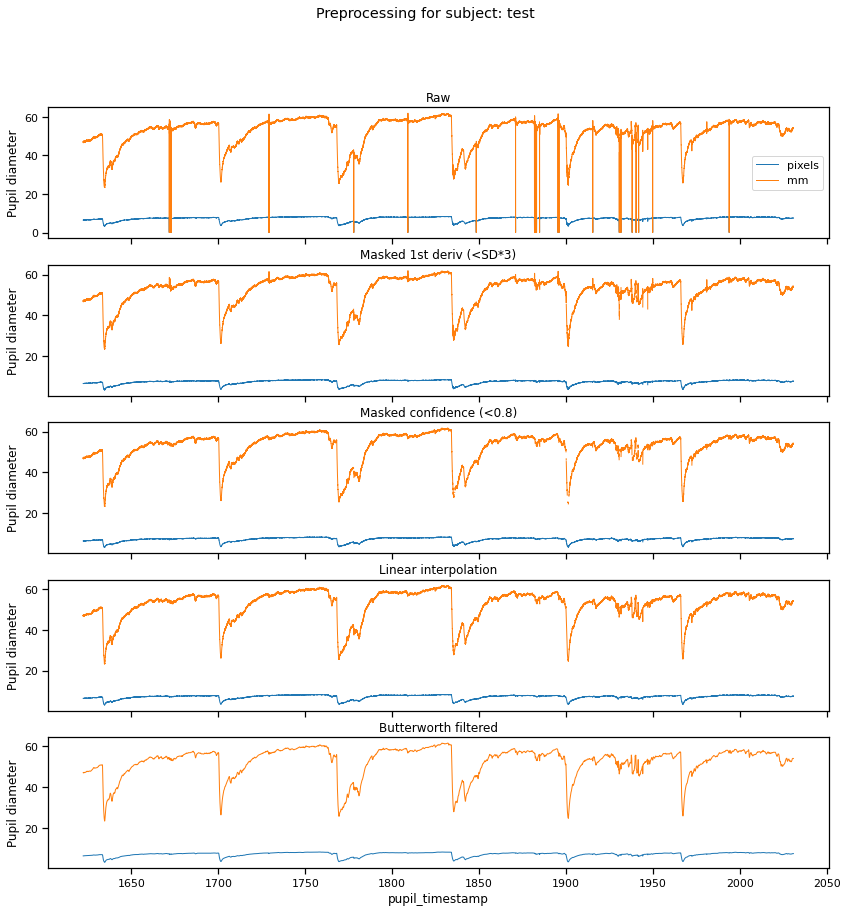

In [25]:
import seaborn as sns
sns.set_context('notebook', rc={"lines.linewidth": 1})
from pyplr import graphing
from pyplr import preproc

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
f, axs = graphing.pupil_preprocessing(nrows=5, subject='test')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['pixels', 'mm'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth  
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3, cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='Butterworth filtered', ax=axs[4], legend=False)

Extraction
----------

To extract data, we first need the annotation events that were sent during the recording, which contain the timestamps that we will need to extract the data.

In [48]:
events = utils.load_annotations(s['data_dir'])
events

Loaded 6 events


,index,label,duration,color,creation_time,creator,protocol,pulse_duration,pulse_spec
timestamp,,,,,,,,,
1633.094863,1289,LIGHT_ON,NaN,blue,2020-12-10 14:46:07.215911,jtm,pulse,1000,"[0, 0, 0, 1800, 0, 0, 0, 0, 0, 0]"
1699.970942,9244,LIGHT_ON,NaN,red,2020-12-10 14:46:07.224217,jtm,pulse,1000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1431]"
1767.858933,17325,LIGHT_ON,NaN,blue,2020-12-10 14:46:07.215911,jtm,pulse,1000,"[0, 0, 0, 1800, 0, 0, 0, 0, 0, 0]"
1833.847199,25178,LIGHT_ON,NaN,blue,2020-12-10 14:46:07.215911,jtm,pulse,1000,"[0, 0, 0, 1800, 0, 0, 0, 0, 0, 0]"
1899.807071,33028,LIGHT_ON,NaN,red,2020-12-10 14:46:07.224217,jtm,pulse,1000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1431]"
1965.779069,40871,LIGHT_ON,NaN,red,2020-12-10 14:46:07.224217,jtm,pulse,1000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1431]"


Now we use the extract utility

In [79]:
from pyplr.extract import extract

DURATION = 7600
ONSET_IDX = 600

# Extract the events and their baselines
ranges = extract(samples, 
                 events, 
                 offset=-ONSET_IDX, 
                 duration=DURATION, 
                 borrow_attributes=['color'])

baselines = ranges.mean(level=0)

# New columns for percent signal change
ranges['diameter_pc'] = (
    ranges.diameter / baselines.diameter - 1).values * 100
ranges['diameter_3dpc'] = (
    ranges.diameter_3d / baselines.diameter_3d - 1).values * 100

ranges

Extracted ranges for 6 events


eye_id  confidence   diameter  method  diameter_3d  interpolated  \
event onset                                                                     
0     0         0.0    0.996302  49.498929  3d c++     6.852567             0   
      1         0.0    0.996329  49.495683  3d c++     6.852178             0   
      2         0.0    0.996053  49.491841  3d c++     6.851707             0   
      3         0.0    0.995299  49.487537  3d c++     6.851172             0   
      4         0.0    0.995408  49.482944  3d c++     6.850598             0   
...             ...         ...        ...     ...          ...           ...   
5     7595      0.0    0.998638  56.251462  3d c++     7.840924             0   
      7596      0.0    0.998745  56.244229  3d c++     7.839922             0   
      7597      0.0    0.998812  56.236904  3d c++     7.838909             0   
      7598      0.0    0.998896  56.229601  3d c++     7.837902             0   
      7599      0.0    0.998675  56.222435  3d c++     7.836917             0   

                orig_idx color  diameter_pc  diameter_3dpc  
event onset                                                 
0     0      1628.258233  blue    -1.124779      -0.209702  
      1      1628.266219  blue    -1.131262      -0.215367  
      2      1628.274167  blue    -1.138937      -0.222229  
      3      1628.282202  blue    -1.147535      -0.230015  
      4      1628.290197  blue    -1.156708      -0.238378  
...                  ...   ...          ...            ...  
5     7595   2022.222443   red     4.296821       4.401248  
      7596   2022.230438   red     4.283410       4.387903  
      7597   2022.238500   red     4.269829       4.374419  
      7598   2022.246457   red     4.256289       4.361013  
      7599   2022.254444   red     4.243001       4.347902  

[45600 rows x 10 columns]

<AxesSubplot:xlabel='onset'>

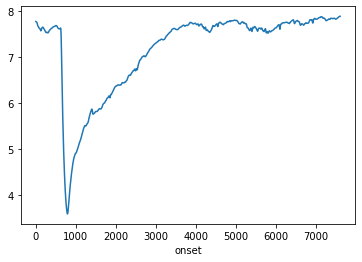

In [83]:
ranges.mean(level=1)['diameter_3d'].plot()